## Status of Voluntary Carbon Market in Canada
- Using the UBerkley Dataset

In [227]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd 
import plotly.express as px
import plotly.graph_objects as go
import json

In [7]:
## UBerkley Data 
uberk_raw = pd.read_excel('../data/offset_registries/UBerkley/UBerk_Voluntary-Registry-Offsets-Database--v2024-12-year-end.xlsx', 
                          sheet_name='PROJECTS', skiprows=3)
raw_cols = pd.DataFrame(uberk_raw.columns)

In [ ]:
# Issuances
uberk_issuances = (uberk_raw.iloc[:, [0] + list(range(23,52))]
                   .melt(id_vars='Project ID', var_name='Vintage', value_name='Issuances')
                   .query("Issuances > 0")
                   .groupby('Project ID')
                   .agg({'Issuances': 'sum',
                         'Vintage': 'min'})
                   .rename(columns={'Vintage': 'First Issuance'})
                   .merge(uberk_raw.iloc[:, [0, 1, 4, 5, 6, 10, 11]], on='Project ID'))

# Retirements 
uberk_retired = (uberk_raw.iloc[:, [0] + list(range(52,82))]
                 .melt(id_vars='Project ID', var_name='Year', value_name='Retirements')
                 .groupby('Project ID')
                 .agg({'Retirements': 'sum'})
                 .merge(uberk_raw.iloc[:, [0, 1, 4, 5, 6, 10, 11]], on='Project ID'))

uberk = uberk_issuances.merge(uberk_retired)

# Global Totals 
global_type = (uberk
               .query("Issuances > 0")
               .groupby(['Region', 'Country', 'Scope'])
               .agg({'Issuances': 'sum',
                     'Retirements': 'sum',
                     'Project ID': 'count'})
               .reset_index().
               rename(columns={"Project ID": "Number of Projects"}))

In [89]:
qa = uberk['First Issuance'].loc[uberk['Country'] == 'United States']

## Global Stats

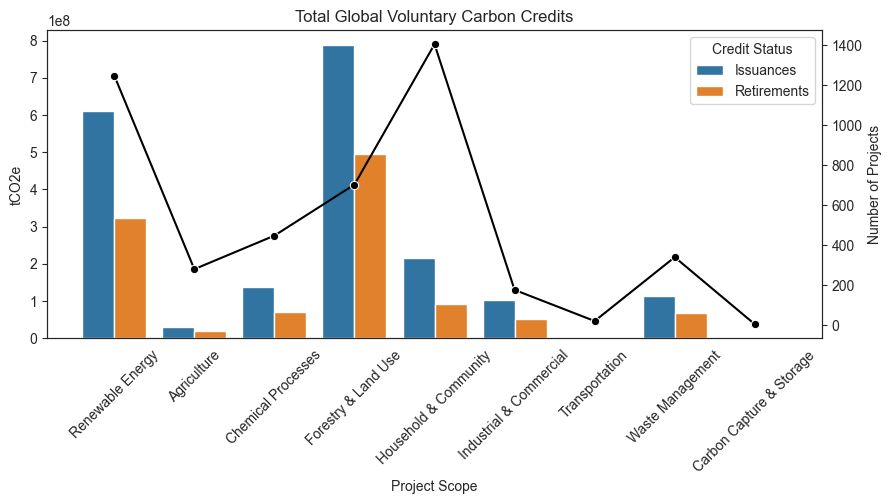

In [ ]:
# Global Bar plot 
sns.set_style("white")
fig, ax1 = plt.subplots(figsize=(10, 4))
sns.barplot(data=global_type.melt(id_vars=['Region', 'Country', 'Scope', 'Number of Projects'], var_name='Credit Status', value_name='tCO2e'), 
            x="Scope", 
            y="tCO2e",
            hue = "Credit Status",
            estimator = 'sum',
            errorbar = None)
ax1.set(
    xlabel = 'Project Scope',
    ylabel = 'tCO2e',
    title = 'Total Global Voluntary Carbon Credits'
    
)
ax1.tick_params(axis='x', labelrotation=45)

# Create Secondary Axis 
ax2 = ax1.twinx()

sns.lineplot(data=global_type, 
             x="Scope", 
             y="Number of Projects", 
             marker="o", 
             color="black", 
             estimator = 'sum',
             errorbar = None,
             ax=ax2)

# Customize secondary axis
ax2.set_ylabel("Number of Projects")
ax2.grid(False)  # Remove grid to keep plot clean

plt.show()

In [147]:
# World Map for number of credits issued to date by country 
fig = px.scatter_geo((global_type
                      .groupby('Country')
                      .agg({'Issuances': 'sum'})
                      .reset_index()), 
                     locations="Country",
                     locationmode='country names',
                     size="Issuances"
                     )

fig.update_geos(
    showcountries=True,   # Show country borders
    countrycolor="black", # Border color
    showcoastlines=True,  # Show coastlines
    coastlinecolor="gray",
    showland=True,        # Show land areas
    landcolor="lightgray"
)

fig.show()

In [ ]:
# Animation Data - total issuances by country and year
df = (uberk_raw.iloc[:, [0] + list(range(23, 52))]
      .melt(id_vars='Project ID', var_name='Vintage', value_name='Issuances')
      .merge(uberk_raw.iloc[:, [0, 1, 4, 5, 6, 10, 11]], on='Project ID')
      .query("Issuances > 0")
      .assign(Number_of_Projects=lambda x: x.groupby('Country')['Issuances'].transform('count'))  # Get number of projects
      .groupby(['Country', 'Vintage', 'Number_of_Projects'])
      .agg({"Issuances": 'sum'})
      .reset_index()
      .sort_values('Vintage'))
df['Has Issuance'] = 'Yes' # dummy var to colour countries that have an issuance

In [243]:
# Global Issuance Year Animation 
fig = px.choropleth(df,
                    locations="Country",
                    locationmode="country names",
                    #color="Has Issuance",  # Just a binary indicator
                    #color_discrete_map={"Yes": "#4682B4"},
                    color = 'Number_of_Projects',
                    color_continuous_scale="Turbo",  # Or any other discrete color scale
                    animation_frame="Vintage"
                    )

# Now create the scatter plot for the issuances
fig_scatter = px.scatter_geo(df,
                              locations="Country",
                              locationmode="country names",
                              size="Issuances",
                              animation_frame="Vintage",
                              hover_name="Country" ,
                              opacity = 0.85)

# Combine traces
fig.add_trace(fig_scatter.data[0])

for i, frame in enumerate(fig.frames):
    fig.frames[i].data += (fig_scatter.frames[i].data[0],)

# Update geos settings for better aesthetics
fig.update_geos(
    showcountries=True,
    countrycolor="gray",  # Borders of countries
    showcoastlines=True,
    coastlinecolor="gray",  # Coastline color
    showland=True  # Show land areas
)

#
#fig.update_layout(
#    autosize=False,
#    width=1000,
#    height=600)


# Show final figure
fig.show()

## Canada General Stats

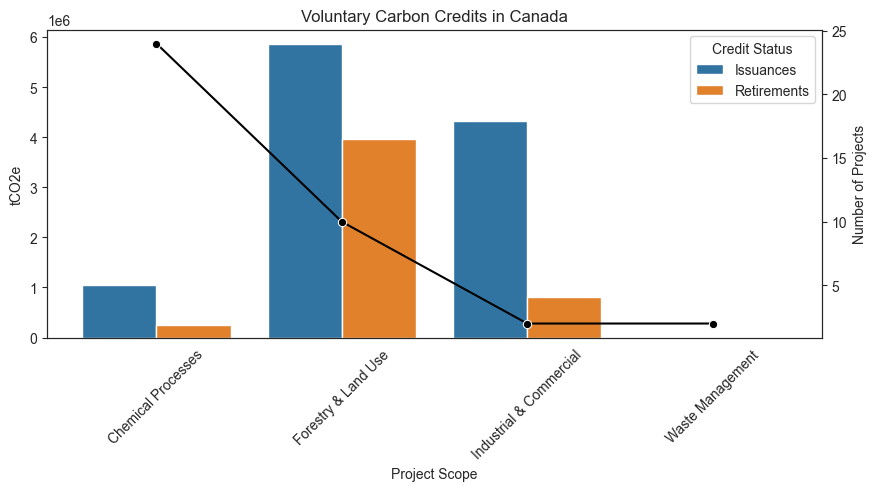

In [104]:
# Projects in Canada:
canada_totals = (global_type
    .loc[lambda df: (df['Country'] == 'Canada') & (df['Number of Projects'] > 0) & (df['Issuances'] > 0)]  # Filter first
    .melt(id_vars=['Region', 'Country', 'Scope', 'Number of Projects'], 
          var_name='Credit Status', value_name='tCO2e')  # Then melt
)

'''
Alternative with query
canada_totals = (global_type
                .melt(id_vars=['Region', 'Country', 'Scope', 'Number of Projects'], var_name='Credit Status', value_name='tCO2e')
                .query("Country == 'Canada'"))
)
'''
# Bar plot 
sns.set_style("white")
fig, ax1 = plt.subplots(figsize=(10, 4))
sns.barplot(data=canada_totals, 
            x="Scope", 
            y="tCO2e",
            hue = "Credit Status",
            estimator = 'sum',
            errorbar = None)
ax1.set(
    xlabel = 'Project Scope',
    ylabel = 'tCO2e',
    title = 'Voluntary Carbon Credits in Canada'
    
)
ax1.tick_params(axis='x', labelrotation=45)

# Create Secondary Axis 
ax2 = ax1.twinx()

sns.lineplot(data=canada_totals, 
             x="Scope", 
             y="Number of Projects", 
             marker="o", 
             color="black", 
             estimator = 'sum',
             errorbar = None,
             ax=ax2)

# Customize secondary axis
ax2.set_ylabel("Number of Projects")
ax2.grid(False)  # Remove grid to keep plot clean

In [105]:
# Country credit contribution vs the World 
country = 'Canada'
sector = 'Forestry & Land Use'
country_proportion = (sum(global_type['Issuances'].loc[global_type['Country'] == country]) 
                      /
                      sum(global_type['Issuances'])) * 100

country_sector = (sum((global_type['Issuances']
                    .loc[(global_type['Scope'] == 'Forestry & Land Use') & 
                        (global_type['Country'] == country)])) 
                 / 
                 sum((global_type['Issuances']
                    .loc[(global_type['Scope'] == sector)]))) * 100

print(f"{country} has issued {round(country_proportion,3)}% of credits globally. For {sector} sector, this is {round(country_sector,3)}%")

Canada has issued 0.56% of credits globally. For Forestry & Land Use sector, this is 0.743%


## Canada Forest Projects 

In [200]:
# BC Registry 
root_BCregistry = '../data/offset_registries/BCcarbon_registry/'
# Issuances ------------------
bc_issuances = (pd.read_csv(f'{root_BCregistry}BCcarbon_registry_issuances.csv')
                .rename(columns = {'Project':'Project Name', 
                                   'Units': 'Issuances', 
                                   'Project Type': 'Scope'}))
bc_issuances['Issuances'] = bc_issuances['Issuances'].str.replace(',', '').astype(float)

# Replace sequestration with Forest to match VCM 
bc_issuances['Scope'] = bc_issuances['Scope'].str.replace('Sequestration', 'Forestry & Land Use')

# Retirements ------------------
bc_retired = (pd.read_csv(f'{root_BCregistry}BCcarbon_registry_retirements.csv')
              .rename(columns = {'Project':'Project Name', 
                                 'Units': 'Retirements'}))

# Fix the weird formatting for retired units
bc_retired_values = bc_retired.iloc[::2].reset_index(drop=True)
bc_retired_extra = (bc_retired.iloc[1::2]
                    .reset_index(drop=True)
                    .rename(columns = {'Retirement Date':'retirement_code', 
                                       'Vintage':'retirement_reason'}))
bc_retired_extra = bc_retired_extra[['retirement_code', 'retirement_reason']]
bc_retired = pd.concat([bc_retired_values, bc_retired_extra], axis=1).drop(columns=['Details'])

In [201]:
# Function to expand vintage into individual years
def expand_vintage(row):
    vintage = row["Vintage"]
    issuance = row["Issuances"]
    project_type = row["Scope"]
    project_name = row["Project Name"]
    verifier = row["Verifier"]
    account = row["Account"]
    
    if " - " in vintage:  # Handle range years
        start_year, end_year = map(int, vintage.split(" - "))
        num_years = end_year - start_year + 1
        return [(year, project_type, project_name, issuance / num_years, verifier, account) for year in range(start_year, end_year + 1)]
    else:  # Handle single year
        return [(int(vintage), project_type, project_name, issuance, verifier, account)]

# Deal with vintages that span multiple years
bc_issuances = [entry for _, row in bc_issuances.iterrows() for entry in expand_vintage(row)]
bc_issuances = pd.DataFrame(bc_issuances, columns=["Vintage", "Scope", "Project Name", 'Issuances', "Verifier", 'Account'])
bc_issuances = (bc_issuances
                .groupby(["Vintage", "Scope", "Project Name", "Verifier", 'Account'])
                .agg({'Issuances': 'sum'})
                .reset_index())

In [197]:
# Map of forest projects and by size
# Bar plot for each province (BC has an extra for its BC registry)
forest_projects = pd.read_csv('../data/offset_registries/forestry_projects_meta.csv')
forest_projects['Lat'] = pd.to_numeric(forest_projects['Lat'], errors='coerce')
forest_projects['Lon'] = pd.to_numeric(forest_projects['Lon'], errors='coerce')

In [219]:
bc_issuances = bc_issuances.merge(forest_projects)

# Rename Great Bear projects
bc_issuances['Project Name'] = bc_issuances['Project Name'].replace({'The Great Bear (North and Central-Mid Coast) Forest Carbon Project-Grandfathered under GGIRCA': 'The Great Bear (North and Central-Mid Coast) Forest Carbon Project',
                                                                     'The Great Bear (Haida Gwaii) Forest Carbon Project-Grandfathered under GGIRCA': 'The Great Bear (Haida Gwaii) Forest Carbon Project',
                                                                     'Great Bear (South Central Coast) Forest Carbon Project-Grandfathered under GGIRCA': 'Great Bear (South Central Coast) Forest Carbon Project'})

In [ ]:
uberk_forest = (uberk_raw.iloc[:, [0] + list(range(23,52))]
                   .melt(id_vars='Project ID', var_name='Vintage', value_name='Issuances')
                   .merge(uberk_raw.iloc[:, [0, 1, 4, 5, 6, 10, 11]], on='Project ID'))
uberk_forest  = (uberk_forest
                 .loc[(uberk_forest['Country'] == "Canada") & (uberk_forest['Scope'] == 'Forestry & Land Use')]
                 .merge(forest_projects))

In [ ]:
# Join all Canadian Projects
canada_forest = pd.concat([uberk_forest, bc_issuances], axis=0)

In [228]:
# Load Canada’s provinces (GeoJSON format)
url = "https://github.com/nvkelso/natural-earth-vector/raw/master/geojson/ne_50m_admin_1_states_provinces.geojson"
canada_provinces = gpd.read_file(url)
canada_provinces = canada_provinces[canada_provinces["admin"] == "Canada"]

In [229]:
# Color Project Status Mapping 
colors_status = {
    "Active": "forestgreen",
    "Under Validation": "darkblue",
    "Withdrawn": "black",
    'Rejected': "red",
    'Under Development': "skyblue",
    'On Hold': "orange"
}

In [ ]:
fig = go.Figure()

# Add provinces of Canada to the map -------------------------------
fig.add_trace(go.Choropleth(
    geojson=json.loads(canada_provinces.to_json()),  # Convert GeoJSON
    locations=canada_provinces['name'],  
    z=[1] * len(canada_provinces),  # Uniform color for all provinces
    colorscale=[[0, 'lightgrey'], [1, 'lightgrey']], # Make all provinces grey
    showscale=False,  # Hide color scale for provinces
    marker_line_width=1, 
    marker_line_color='black',  
    hoverinfo='location',  # Show province name on hover - from the locations parameter
    featureidkey="properties.name" 
))

# Location of forest offset projects ------------------------
# Apply jitter only if there are multiple coordinates at the same location
jitter_strength = 0.6
lat_lon_counts = meta_projects.groupby(['Lat', 'Lon']).size().reset_index(name='counts')
temp_df = meta_projects.merge(lat_lon_counts, on=['Lat', 'Lon'], how='left')
jittered_lat = temp_df['Lat'].copy()
jittered_lon = temp_df['Lon'].copy()
mask = temp_df['counts'] > 1
jittered_lat[mask] += np.random.uniform(-jitter_strength, jitter_strength, size=mask.sum())
jittered_lon[mask] += np.random.uniform(-jitter_strength, jitter_strength, size=mask.sum())
del temp_df

# Prepare hover text
meta_projects['hover_text'] = meta_projects.apply(
    lambda row: (
        "<b>Project Name:</b> " + row['Project Name'] + "<br>" +
        "<b>Project Proponent:</b> " + row['Project Proponent'] + "<br>" +
        "<b>Project Type:</b> " + row['Type'] + "<br>" +
        "<b>Registry:</b> " + row['Registry'] + "<br>" +
        "<b>Status:</b> " + row['Status'] + "<br>" + 
        "<b>Total Issuances:</b> " + f"{row['Total Issuances']}" + "<br>"
        # Add year of first issuance? 
    ), axis=1
)

# Replace NaN values in 'Total Issuances' with a default size (ones with no issuances yet)
default_size = 7

# Normalize the 'Total Issuances' to a suitable range for marker sizes
max_marker_size = 40
min_marker_size = 10

# Create a new column 'marker_size' with default size for NaN values
meta_projects['marker_size'] = meta_projects['Total Issuances'].apply(
    lambda x: default_size if pd.isna(x) or x == 0 else (
        (x - meta_projects['Total Issuances'].min()) /
        (meta_projects['Total Issuances'].max() - meta_projects['Total Issuances'].min()) *
        (max_marker_size - min_marker_size) + min_marker_size
    )
)

fig.add_trace(go.Scattergeo(
    lat=jittered_lat,
    lon=jittered_lon,
    mode='markers',
    marker=dict(
        size=meta_projects["marker_size"],  
        color=meta_projects["Status"].map(colors_status),  
        symbol=meta_projects["Voluntary/Compliance"].map({
            "Voluntary": "circle",
            "Compliance": "diamond"
        }),
    ),
    text=meta_projects['hover_text'],  # Use the formatted hover text
    hoverinfo="text",  # Hover information
    name=''
))
# Add a legend for the symbols
for compliance, symbol in {"Voluntary": "circle", "Compliance": "diamond"}.items():
    fig.add_trace(go.Scattergeo(
        lat=[None], lon=[None],
        mode='markers',
        marker=dict(size=10, symbol=symbol, color='grey'),
        name=compliance
    ))

# Add a legend for the color of the points based on the colors_status dict
for status, color in colors_status.items():
    fig.add_trace(go.Scattergeo(
        lat=[None], lon=[None],
        mode='markers',
        marker=dict(size=10, color=color),
        name=status
        ))

# Make the plot size bigger
fig.update_layout(
    title='Forest Offset Projects in Canada',
    width=1000,
    height=800,
    geo=dict(
        scope='north america',
        projection_type='equirectangular',
        center={"lat": 56.1304, "lon": -106.3468},  # Center on Canada
        showland=True,  # Show land
        landcolor='rgba(0, 0, 0, 0)'  # Land color (transparent)
    ),
    hoverlabel=dict(
        bgcolor="white",
        font_size=12,
        font_family="Arial"
    ),
    uirevision='constant'  # Keep hover open when you click on it
)

fig.show()

In [242]:
## Map of all projects in Canada
fig = go.Figure()

# Add provinces of Canada to the map -------------------------------
fig.add_trace(go.Choropleth(
    geojson=json.loads(canada_provinces.to_json()),  # Convert GeoJSON
    locations=canada_provinces['name'],  
    showscale=False,  
    z=[1] * len(canada_provinces),  # Uniform color for all provinces
    colorscale=[[0, 'lightgrey'], [1, 'lightgrey']], # Make all provinces grey
    hoverinfo='location',  
    featureidkey="properties.name" 
))

# Location of forest offset projects ------------------------
# Apply jitter only if there are multiple coordinates at the same location
jitter_strength = 0.6
lat_lon_counts = canada_forest.groupby(['Lat', 'Lon']).size().reset_index(name='counts')
temp_df = canada_forest.merge(lat_lon_counts, on=['Lat', 'Lon'], how='left')
jittered_lat = temp_df['Lat'].copy()
jittered_lon = temp_df['Lon'].copy()
mask = temp_df['counts'] > 1
jittered_lat[mask] += np.random.uniform(-jitter_strength, jitter_strength, size=mask.sum())
jittered_lon[mask] += np.random.uniform(-jitter_strength, jitter_strength, size=mask.sum())
del temp_df

# Replace NaN values in 'Total Issuances' with a default size (ones with no issuances yet)
default_size = 7
# Normalize the 'Total Issuances' to a suitable range for marker sizes
max_marker_size = 40
min_marker_size = 10

# Create a new column 'marker_size' with default size for NaN values
canada_forest['marker_size'] = canada_forest['Total Issuances'].apply(
    lambda x: default_size if pd.isna(x) or x == 0 else (
        (x - canada_forest['Total Issuances'].min()) /
        (canada_forest['Total Issuances'].max() - canada_forest['Total Issuances'].min()) *
        (max_marker_size - min_marker_size) + min_marker_size
    )
)


# Remove base map 
fig.update_geos(
    showcoastlines=False,
    showland=False,
    fitbounds="locations" # to zoom into Canada
)


KeyError: 'Total Issuances'